In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
from torchvision import models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

import matplotlib.pyplot as plotter_lib

from torch.utils.data import DataLoader,Dataset
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd

torch.autograd.set_detect_anomaly(True)

In [2]:
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

True
NVIDIA GeForce RTX 3070 Laptop GPU


In [3]:
# Define the data transforms to be applied to the images
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
from turbojpeg import TurboJPEG
from concurrent.futures import ThreadPoolExecutor
from turbojpeg import TurboJPEG

# Specify the correct path to the turbojpeg library
lib_path = r'C:\libjpeg-turbo-gcc64\bin\libturbojpeg.dll'
jpeg = TurboJPEG(lib_path)

class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, mode, transform=None, batch_size=64):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size

        # List to hold image paths and corresponding labels
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for image_name in os.listdir(os.path.join(self.root_dir, self.mode)):
            if image_name.startswith("cat"):
                label = 0  # Label for cat
            elif image_name.startswith("dog"):
                label = 1  # Label for dog
            else:
                continue

            image_path = os.path.join(self.root_dir, self.mode, image_name)
            self.image_paths.append(image_path)
            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Load image using TurboJPEG when requested
        image_path = self.image_paths[index]
        with open(image_path, 'rb') as image_file:
            image_data = image_file.read()
            image = jpeg.decode(image_data)  # Decode JPEG
            image = Image.fromarray(image)  # Convert to PIL Image

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Resize the high-resolution image to low-resolution
        image_low = transforms.Resize((32, 32))(image)

        label = self.labels[index]

        # Return both resolutions and the label
        return image_low, image, label

In [5]:
# Set the main directory for the dataset
main_dir = r'./Data/'
print("Initializing DataLoader...")

# Create dataset instances for train and test
image_datasets = {
    'train': CatsDogsDataset(root_dir=main_dir, transform=train_transform, mode='train'),
    'test': CatsDogsDataset(root_dir=main_dir, transform=test_transform, mode='test1')
}
print("DataLoader initialized.")

# Create DataLoaders for the datasets
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=0, pin_memory=False),    
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=0, pin_memory=False)
}

print("Fetching a batch of data from DataLoader...")
# Get a batch of data from the train DataLoader
image_low, image_high, labels = next(iter(dataloaders['train']))

# Print the number of images in the train and test sets
print(f"Number of images in train set: {len(image_datasets['train'])}")
print(f"Number of images in test set: {len(image_datasets['test'])}")


Initializing DataLoader...
DataLoader initialized.
Fetching a batch of data from DataLoader...
Number of images in train set: 25000
Number of images in test set: 0
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 128, 128])


In [6]:
print(image_low.shape)
print(image_high.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8687869..2.5890913].


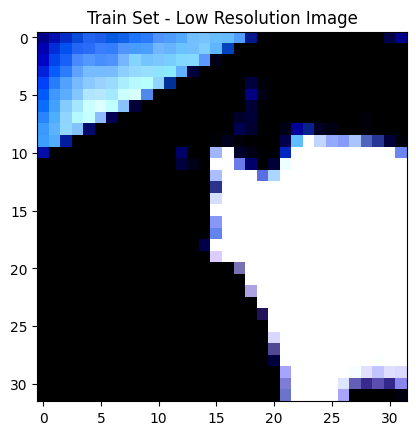

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].


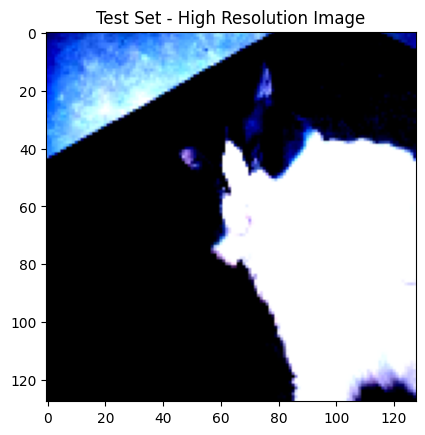

In [7]:
import matplotlib.pyplot as plt

# Display an image from the train set
plt.imshow(image_low[0].permute(1,2,0))
plt.title('Train Set - Low Resolution Image')
plt.show()

# Display an image from the test set
plt.imshow(image_high[0].permute(1,2,0))
plt.title('Test Set - High Resolution Image')
plt.show()


In [8]:
# Define a function to visualize a low-resolution image, a high-resolution image, and a generated image.
def visualize(lr_image, hr_image, generated_image, label, epoch, pretrain, show=False):
    # Move the tensors to the CPU and detach the generated_image tensor.
    lr_image = lr_image.cpu().detach().permute(1, 2, 0).numpy()
    hr_image = hr_image.cpu().detach().permute(1, 2, 0).numpy()
    generated_image = generated_image.cpu().detach().permute(1, 2, 0).numpy()

    # Normalize the pixel values to the range [0, 1] for visualization.
    lr_image = (lr_image - lr_image.min()) / (lr_image.max() - lr_image.min())
    hr_image = (hr_image - hr_image.min()) / (hr_image.max() - hr_image.min())
    generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())

    # Plot the images.
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(lr_image)
    axes[0].set_title("Low Resolution")
    axes[1].imshow(hr_image)
    axes[1].set_title("High Resolution")
    axes[2].imshow(generated_image)
    axes[2].set_title("Generated Image")

    # Add some padding to the top of the figure.
    fig.subplots_adjust(top=0.85)

    # Add a common title to the figure depending on the pretrain flag.
    if pretrain:
        fig.suptitle(f" Epoch {epoch} - {label}")
    else:
        fig.suptitle(f"Epoch {epoch} - {label}")
    
    # Create the 'output' directory if it doesn't exist.
    if not os.path.exists('./output'):
        os.makedirs('./output')
    
    # Save and show the figure every 5 epochs or if the show flag is set to True.
    if epoch % 5 == 0 or show:
        fig.savefig(f"./output/epoch_{epoch}_{label}.png")
        plt.show()
    else:
        plt.close(fig)

In [9]:
class residual(nn.Module):
    def __init__(self, num_res_blocks=16):
        super().__init__()
        self.num_res_blocks = num_res_blocks
        
        # First layer
        self.conv1 = nn.Sequential(
            nn.LazyConv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        
        # Add Residual blocks
        res_blocks = []
        for i in range(num_res_blocks):
            res_blocks.append(residual(64))
        self.res_blocks = nn.Sequential(*res_blocks)
        
        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(
            nn.LazyConv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d()
        )
        
        # Upsampling Layers
        upsample_layers = []
        for out_channels in [32, 16, 4]:
            upsample_layers += [
                nn.LazyConvTranspose2d(64, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.PReLU()
            ]
        self.upsample_layers = nn.Sequential(*upsample_layers)
        
        # Final output layer
        self.output_layer = nn.Sequential(
            nn.LazyConv2d(4, 3, kernel_size=9, padding=4),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.conv1(x)
        residual = x
        x = self.res_blocks(x)
        x = self.conv2(x)
        x += residual
        x = self.upsample_layers(x)
        x = self.output_layer(x)
        return x


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.generator = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=9, stride=1, padding=4),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        out = self.generator(x)

        return out


In [11]:
generator = Generator().to(device)
test_input = torch.rand(1,3,32,32).to(device)
print(generator(test_input).shape)

torch.Size([1, 3, 128, 128])


In [12]:
# Define a class for the pre-training generator
class pretraining_generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrain = True
        self.mse_loss = nn.MSELoss()

    def forward(self, sr, hr):
        # Calculate the content loss between SR and HR images
        content_loss = self.mse_loss(sr, hr)
        return content_loss
    
import torch.nn.functional as F
from torchvision.models import vgg19

# Define a class for the generator loss function
class generator_loss(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a VGG19 model pre-trained on ImageNet
        self.vgg = vgg19(pretrained=True).features[:35].eval()
        # Freeze the parameters of the VGG19 model
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.mse_loss = nn.MSELoss()

    def forward(self, sr, hr, discriminator_fake_output):
        # Calculate the content loss between SR and HR images using the VGG19 model
        with torch.no_grad():
            hr_vgg = self.vgg(hr)
        sr_vgg = self.vgg(sr)
        content_loss = self.mse_loss(sr_vgg, hr_vgg)

        # Calculate the adversarial loss using the discriminator output
        adversarial_loss = F.binary_cross_entropy(discriminator_fake_output, torch.ones_like(discriminator_fake_output))

        # Calculate the total generator loss as a weighted sum of the content and adversarial losses
        generator_loss = content_loss + 1e-3 * adversarial_loss

        return generator_loss

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(64, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(128, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(128, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(256, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(256, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(512, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(512, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2)
        )
            
       

        # Add the fully connected part before the final nn.Linear layer
        self.fc = nn.Sequential(
            nn.LazyLinear(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        # Pass the output through the discriminator blocks (body)
        x = self.body(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Pass the output through the fully connected part
        x = self.fc(x)

        return x

In [14]:
class discriminator_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, real_pred, fake_pred):
        real_label = torch.ones_like(real_pred)
        fake_label = torch.zeros_like(fake_pred)

        # Loss for real high-resolution images
        real_loss = self.bce_loss(real_pred, real_label)

        # Loss for generated high-resolution images
        fake_loss = self.bce_loss(fake_pred, fake_label)

        # Total discriminator loss
        total_loss = (real_loss + fake_loss) * 0.5
        return total_loss

In [15]:
discriminator = Discriminator().to(device)
test_input = torch.rand(1,3,128,128).to(device)
print(discriminator(test_input).shape)

torch.Size([1, 1])


In [16]:
# Create the 'models' directory if it doesn't exist
if not os.path.exists('./models'):
    os.makedirs('./models')

In [17]:
# Load the data
train_loader = dataloaders['train']
test_loader = dataloaders['test']
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of epochs and the batch size
num_epochs = 100 # 50 epochs of pretraining + 100 of both = 150 total epochs
batch_size = 48
lr = 0.0001
bar_width=150

# Define the loss functions
pretrain_generator_loss = pretraining_generator().to(device)
generator_loss_fn = generator_loss().to(device)
discriminator_loss_fn = discriminator_loss().to(device)

# Move the model parameters to the device
generator.to(device)
discriminator.to(device)

# Define the optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Load the data
train_loader = dataloaders['train']
test_loader = dataloaders['test']

pretrain_loss = []
generator_loss_history = []
discriminator_loss_history = []

c:\Users\alway\anaconda3\envs\applied-ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alway\anaconda3\envs\applied-ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
from tqdm import tqdm
# Pre-training phase
print("Starting pre-training phase...")
for epoch in range(50):
    generator.train()
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{50}",ncols=bar_width)
    
    for i, (lr_images, hr_images, _) in enumerate(train_loader):
        # Move the data to the device
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Generate the super-resolved images
        sr_images = generator(lr_images)

        # Compute the loss and update the parameters
        generator_loss_value = pretrain_generator_loss(sr_images, hr_images)
        generator_optimizer.zero_grad()
        generator_loss_value.backward(retain_graph=True)
        generator_optimizer.step()

        pretrain_loss.append(generator_loss_value.item())
        
        # Print the loss value every 10 batches
        if (i+1) % 10 == 0:
            pbar.set_postfix({"Gen loss": f"{generator_loss_value.item():.4f}"})
        pbar.update()

    pbar.close()
    
    
    # Save the generator model every 5 epochs
    #if (epoch+1) % 5 == 0:
        #torch.save(generator.state_dict(), f"./models/generator_model_{epoch+1}.pt")

    # Save the generated images for visualization
    generator.eval()
    with torch.no_grad():
        lr_images, hr_images, _ = next(iter(test_loader))
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        sr_images = generator(lr_images)
        visualize(lr_images[0], hr_images[0], sr_images[0], "Pre-Training", epoch+1, True)

# Adversarial training phase
print("Starting adversarial training phase...")
                         
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", ncols=bar_width)
    for i, (lr_images, hr_images, _) in enumerate(train_loader):
        # Move the data to the device
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        # Generate the super-resolved images
        sr_images = generator(lr_images)

        # Train the discriminator
        discriminator_optimizer.zero_grad()

        real_labels = torch.ones(hr_images.size(0), 1).to(device)
        fake_labels = torch.zeros(hr_images.size(0), 1).to(device)

        discriminator_real_output = discriminator(hr_images)
        discriminator_fake_output = discriminator(sr_images)

        discriminator_loss_fn = discriminator_loss().to(device)

        discriminator_real_loss = discriminator_loss_fn(discriminator_real_output, real_labels)
        discriminator_fake_loss = discriminator_loss_fn(discriminator_fake_output, fake_labels)

        discriminator_loss_value = discriminator_real_loss + discriminator_fake_loss
        discriminator_loss_value.backward()
        discriminator_optimizer.step()


        # Train the generator
        generator_optimizer.zero_grad()
        sr_images = generator(lr_images)
        discriminator_fake_output = discriminator(sr_images)

        generator_loss_value = generator_loss_fn(sr_images, hr_images, discriminator_fake_output)
        generator_loss_value.backward()
        generator_optimizer.step()

        discriminator_loss_history.append(discriminator_loss_value.item())
        generator_loss_history.append(generator_loss_value.item()) # moved here


        # Get new data from the train_loader
        lr_images, hr_images, _ = next(iter(train_loader))
        lr_images = lr_images.detach()
        hr_images = hr_images.detach()
        
        # Print the loss value every 10 batches
        if (i+1) % 10 == 0:
            pbar.set_postfix({"Gen loss": f"{generator_loss_value.item():.4f}", "Discr loss": f"{discriminator_loss_value.item():.4f}"})
        pbar.update()



    pbar.close()
    # Save the generator and discriminator models every 5 epochs
    if (epoch+1) % 5 == 0:
        torch.save(generator.state_dict(), f"./models/generator_epoch_{epoch+1}.pt")
        torch.save(discriminator.state_dict(), f"./models/discriminator_epoch_{epoch+1}.pt")

    # Save the generated images for visualization
    generator.eval()
    with torch.no_grad():
        lr_images, hr_images, _ = next(iter(test_loader))
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        sr_images = generator(lr_images)
        visualize(lr_images[0], hr_images[0], sr_images[0], "Adversarial Training", epoch+1, True)


Starting pre-training phase...


Epoch 1/50:  23%|██████████████████▉                                                               | 181/782 [00:47<02:35,  3.88it/s, Gen loss=0.1760]

KeyboardInterrupt: 

In [ ]:
from IPython.display import Image

Image(filename='./output/epoch_30_Adversarial Training.png')
#last epoch